In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
%matplotlib inline
from sklearn.metrics import confusion_matrix
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1  
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

Using TensorFlow backend.


In [2]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [3]:
def build_model(train_x,train_y,n_input,n_out):
	# define parameters
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
	# define model

	model = Sequential()
	model.add(LSTM(256, activation='linear', input_shape=(n_timesteps, n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='linear'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 


In [4]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

(828, 10)
(828,)


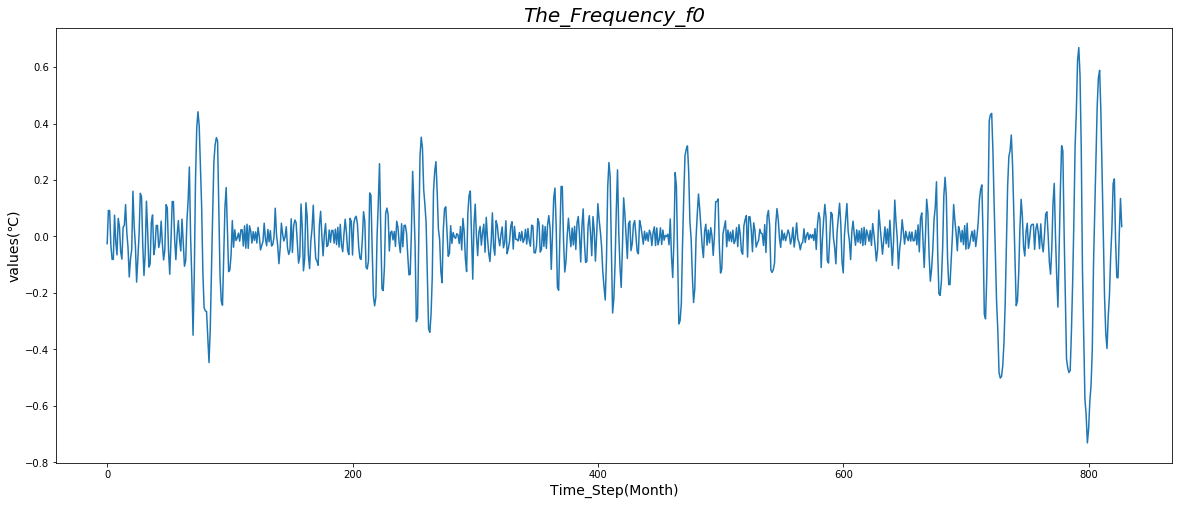

(1, 12, 1)
[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
(792, 12, 1)
(792, 12)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 3s - loss: 0.0190
Epoch 2/200
 - 1s - loss: 0.0171
Epoch 3/200
 - 1s - loss: 0.0168
Epoch 4/200
 - 1s - loss: 0.0167
Epoch 5/200
 - 1s - loss: 0.0162
Epoch 6/200
 - 1s - loss: 0.0158
Epoch 7/200
 - 1s - loss: 0.0158
Epoch 8/200
 - 1s - loss: 0.0159
Epoch 9/200
 - 1s - loss: 0.0159
Epoch 10/200
 - 1s - loss: 0.0159
Epoch 11/200
 - 1s - loss: 0.0164
Epoch 12/200
 - 1s - loss: 0.0158
Epoch 13/200
 - 1s - loss: 0.0159
Epoch 14/200
 - 1s - loss: 0.0157
Epoch 15/200
 - 1s - loss: 0.0155
Epoch 16/200
 - 1s - loss: 0.0155
Epoch 17/200
 - 1s - loss: 0.0155
Epoch 18/200
 - 1s - loss: 0.

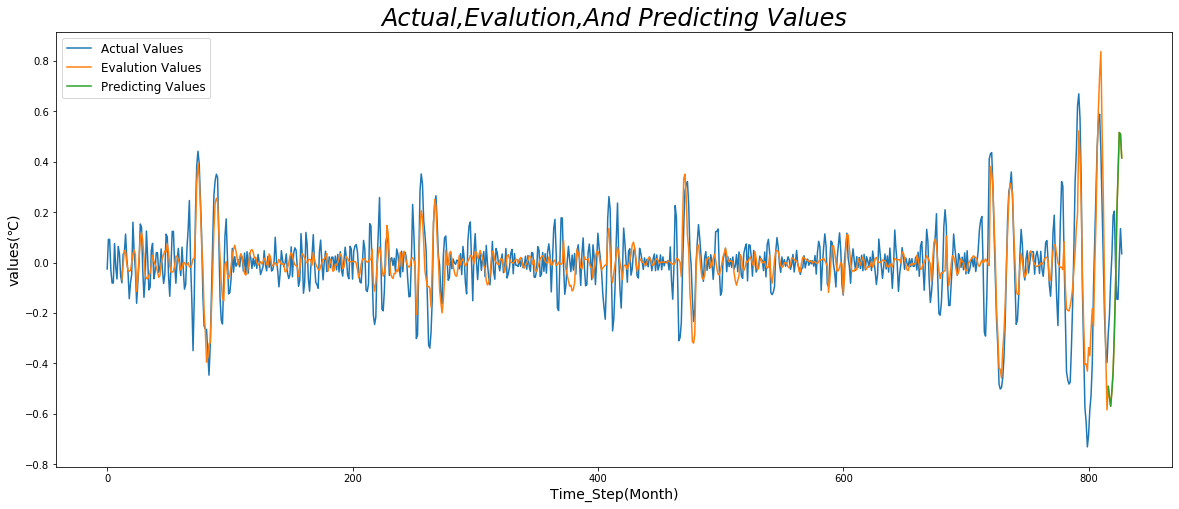

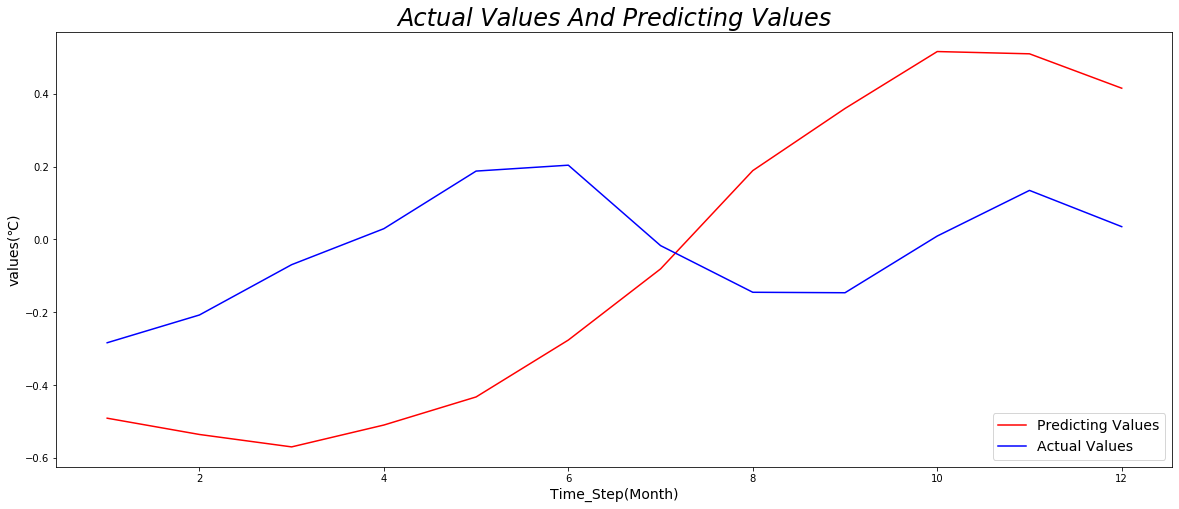

(828,)


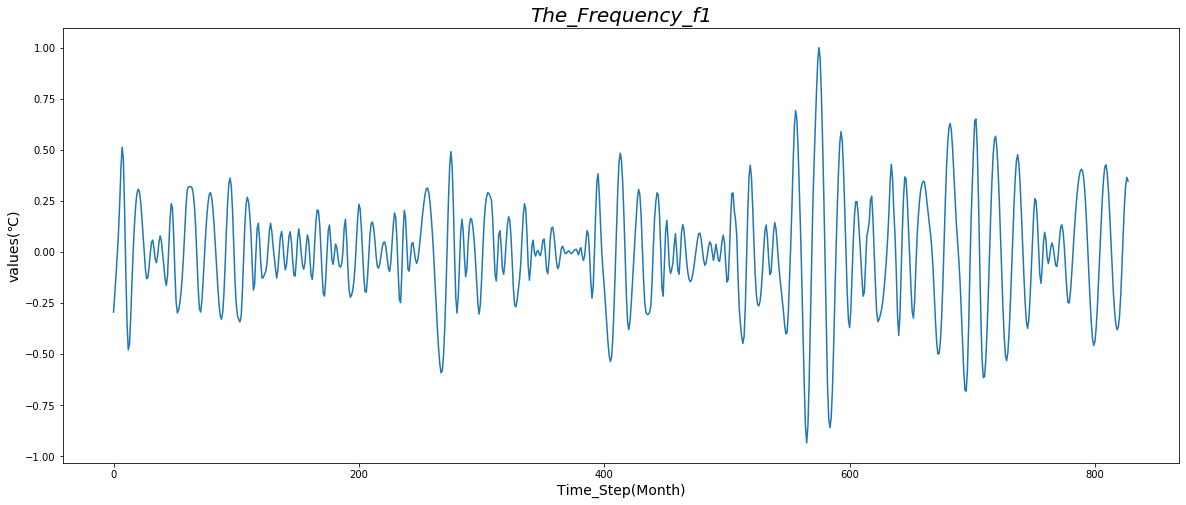

(1, 12, 1)
[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 3s - loss: 0.0470
Epoch 2/200
 - 1s - loss: 0.0370
Epoch 3/200
 - 1s - loss: 0.0350
Epoch 4/200
 - 1s - loss: 0.0338
Epoch 5/200
 - 1s - loss: 0.0340
Epoch 6/200
 - 1s - loss: 0.0335
Epoch 7/200
 - 1s - loss: 0.0333
Epoch 8/200
 - 1s - loss: 0.0323
Epoch 9/200
 - 1s - loss: 0.0326
Epoch 10/200
 - 1s - loss: 0.0318
Epoch 11/200
 - 1s - loss: 0.0316
Epoch 12/200
 - 1s - loss: 0.0316
Epoch 13/200
 - 1s - loss: 0.0315
Epoch 14/200
 - 1s - loss: 0.0309
Epoch 15/200
 - 1s - loss: 0.0316
Epoch 16/200
 - 1s - loss: 0.0311
Epoch 17/200
 - 1s - loss: 0.0306
Epoch 18/200
 - 1s - loss: 0.0305
Epoch 19/200
 - 1s - loss: 0.0319
Epoch 20/200
 - 1s - loss: 0.0300
Epoch 21/200
 - 1s - loss: 0.0309
Epoch 22/200
 - 1s - loss: 0.0306
Epoch 23/200
 - 1s - loss: 0.0299
Epoch 24/200
 - 1s - loss: 0.0304
Epoch 25/200
 - 1s - loss: 0.0301
Ep

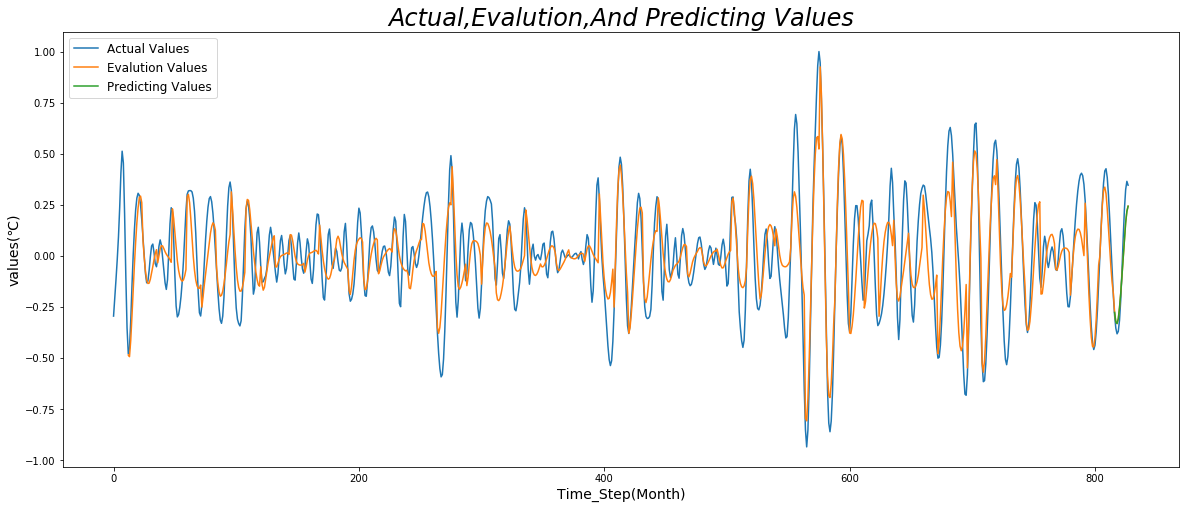

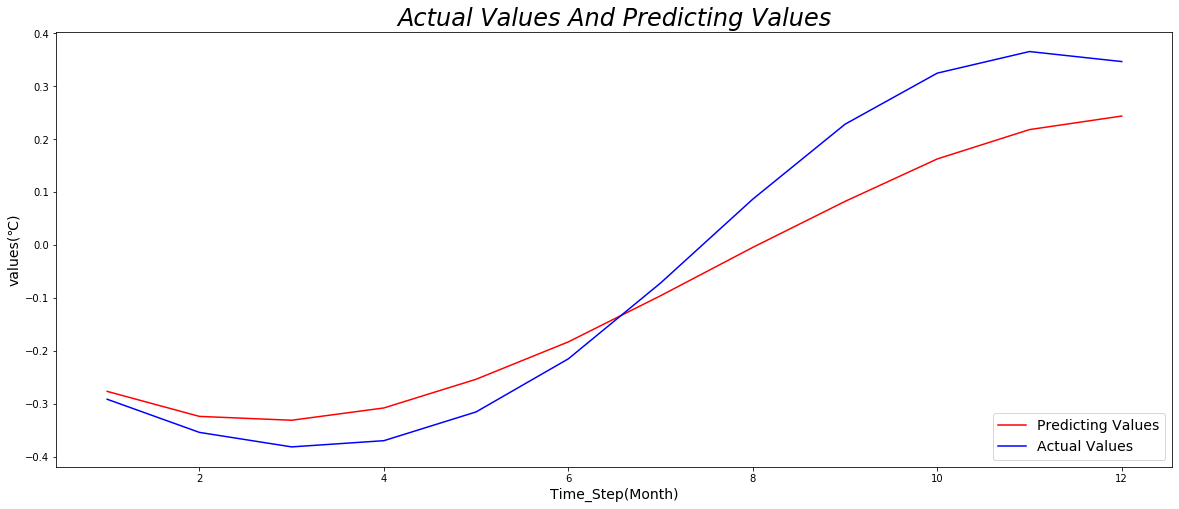

(828,)


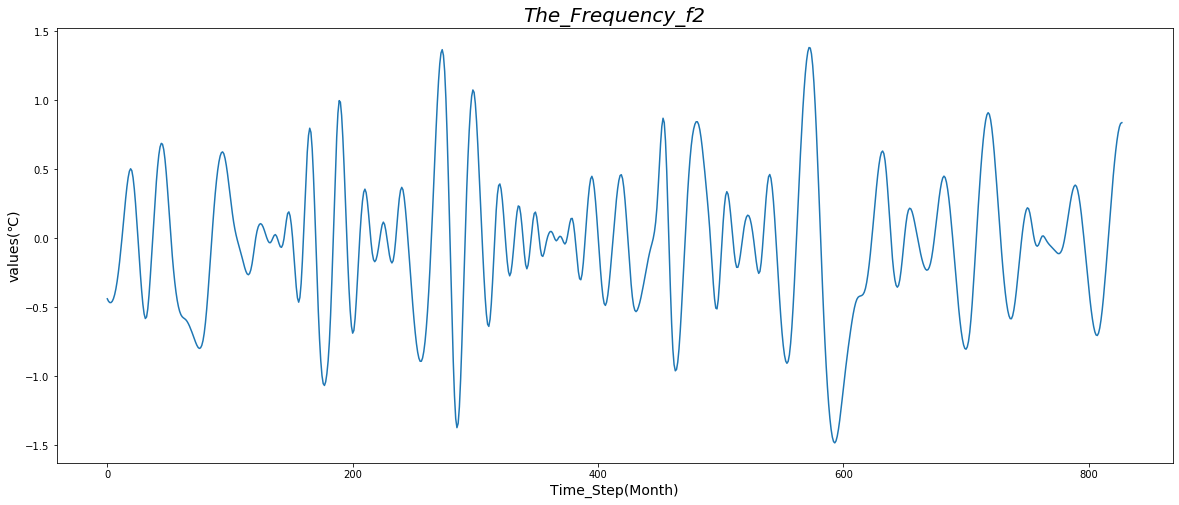

(1, 12, 1)
[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70665   0.76531   0.80793   0.83261   0.83806  ]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 3s - loss: 0.2026
Epoch 2/200
 - 1s - loss: 0.1470
Epoch 3/200
 - 1s - loss: 0.1353
Epoch 4/200
 - 1s - loss: 0.1266
Epoch 5/200
 - 1s - loss: 0.1224
Epoch 6/200
 - 1s - loss: 0.1211
Epoch 7/200
 - 1s - loss: 0.1126
Epoch 8/200
 - 1s - loss: 0.1046
Epoch 9/200
 - 1s - loss: 0.1001
Epoch 10/200
 - 1s - loss: 0.1095
Epoch 11/200
 - 1s - loss: 0.1029
Epoch 12/200
 - 1s - loss: 0.0985
Epoch 13/200
 - 1s - loss: 0.0967
Epoch 14/200
 - 1s - loss: 0.0963
Epoch 15/200
 - 1s - loss: 0.0960
Epoch 16/200
 - 1s - loss: 0.0924
Epoch 17/200
 - 1s - loss: 0.0913
Epoch 18/200
 - 1s - loss: 0.0925
Epoch 19/200
 - 1s - loss: 0.0922
Epoch 20/200
 - 1s - loss: 0.0907
Epoch 21/200
 - 1s - loss: 0.0846
Epoch 22/200
 - 1s - loss: 0.0878
Epoch 23/200
 - 1s - loss: 0.0852
Epoch 24/200
 - 1s - loss: 0.0840
Epoch 25/200
 - 1s - loss: 0.0825
Epoc

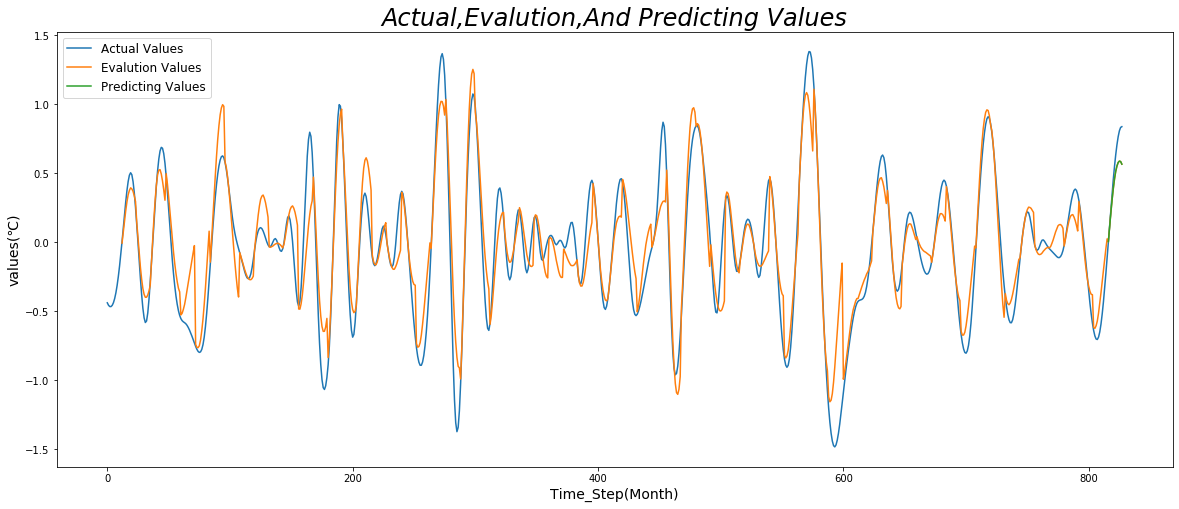

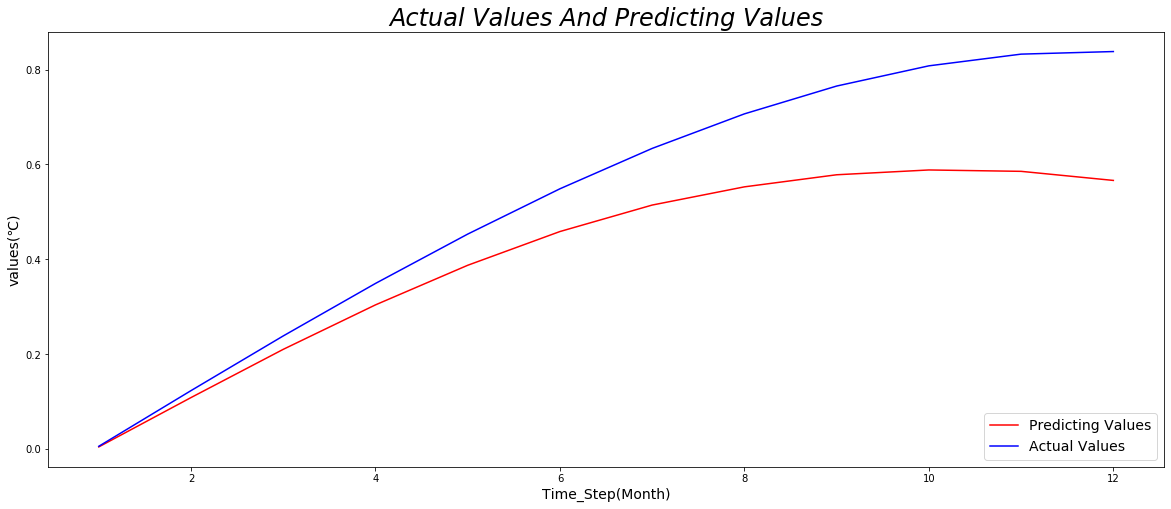

(828,)


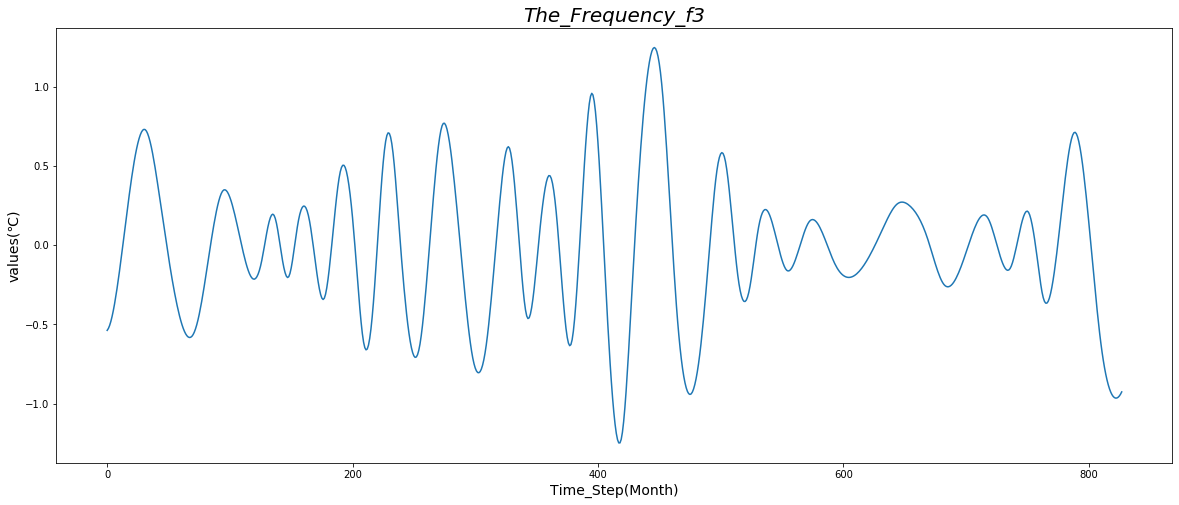

(1, 12, 1)
[-0.88131 -0.90671 -0.92735 -0.94342 -0.95507 -0.96249 -0.96584 -0.96529
 -0.96101 -0.95309 -0.94162 -0.92675]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 5s - loss: 0.1228
Epoch 2/200
 - 1s - loss: 0.0525
Epoch 3/200
 - 1s - loss: 0.0405
Epoch 4/200
 - 1s - loss: 0.0373
Epoch 5/200
 - 1s - loss: 0.0348
Epoch 6/200
 - 2s - loss: 0.0331
Epoch 7/200
 - 1s - loss: 0.0330
Epoch 8/200
 - 1s - loss: 0.0298
Epoch 9/200
 - 1s - loss: 0.0315
Epoch 10/200
 - 1s - loss: 0.0294
Epoch 11/200
 - 1s - loss: 0.0283
Epoch 12/200
 - 1s - loss: 0.0318
Epoch 13/200
 - 1s - loss: 0.0298
Epoch 14/200
 - 1s - loss: 0.0288
Epoch 15/200
 - 1s - loss: 0.0274
Epoch 16/200
 - 1s - loss: 0.0314
Epoch 17/200
 - 1s - loss: 0.0284
Epoch 18/200
 - 1s - loss: 0.0261
Epoch 19/200
 - 1s - loss: 0.0276
Epoch 20/200
 - 1s - loss: 0.0279
Epoch 21/200
 - 1s - loss: 0.0271
Epoch 22/200
 - 1s - loss: 0.0270
Epoch 23/200
 - 1s - loss: 0.0253
Epoch 24/200
 - 1s - loss: 0.0239
Epoch 25/200
 - 1s - loss: 0.0257
Epoch 26/200
 

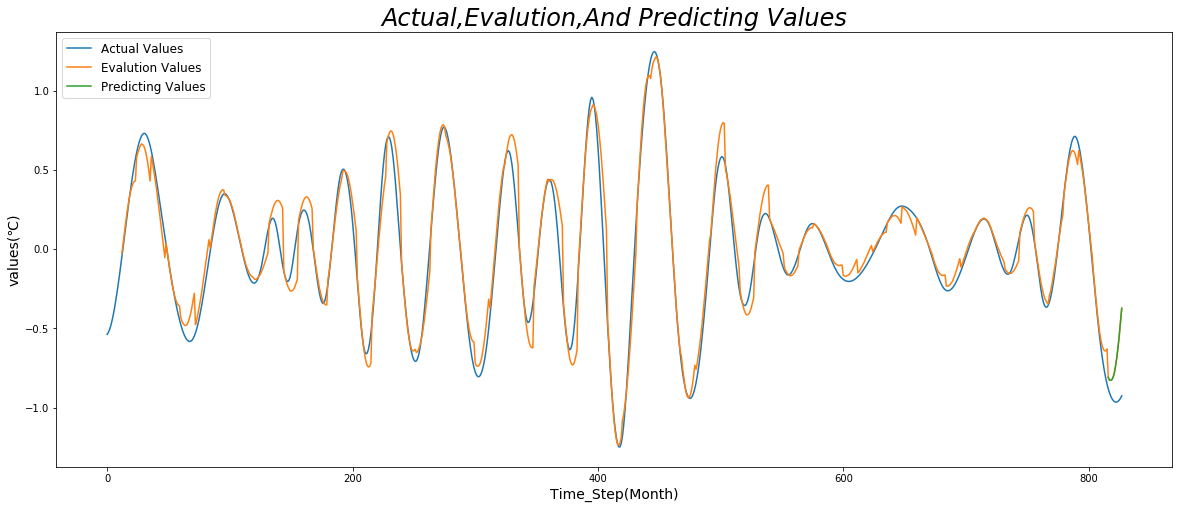

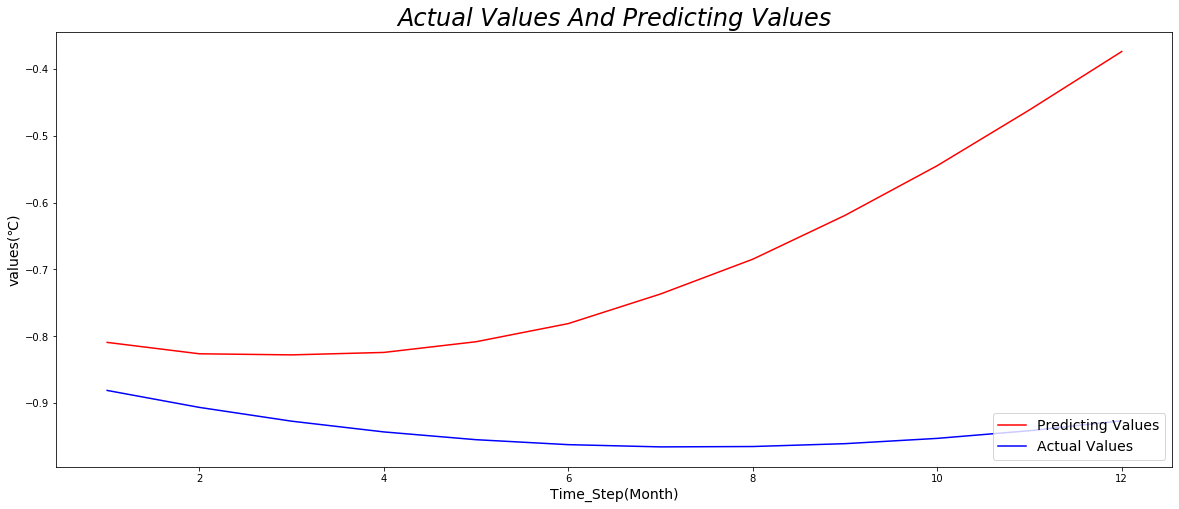

(828,)


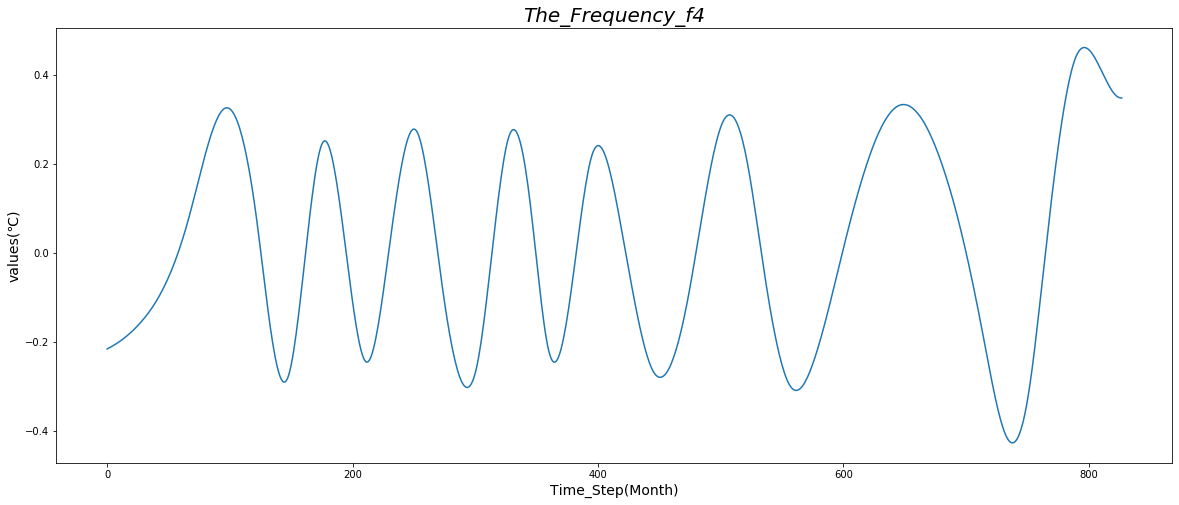

(1, 12, 1)
[0.37911 0.37411 0.36941 0.36506 0.36112 0.35764 0.35466 0.35226 0.35045
 0.34923 0.34856 0.34841]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 4s - loss: 0.0228
Epoch 2/200
 - 1s - loss: 0.0057
Epoch 3/200
 - 1s - loss: 0.0031
Epoch 4/200
 - 1s - loss: 0.0024
Epoch 5/200
 - 1s - loss: 0.0020
Epoch 6/200
 - 2s - loss: 0.0023
Epoch 7/200
 - 1s - loss: 0.0021
Epoch 8/200
 - 2s - loss: 0.0020
Epoch 9/200
 - 2s - loss: 0.0019
Epoch 10/200
 - 2s - loss: 0.0019
Epoch 11/200
 - 1s - loss: 0.0018
Epoch 12/200
 - 1s - loss: 0.0017
Epoch 13/200
 - 1s - loss: 0.0021
Epoch 14/200
 - 1s - loss: 0.0018
Epoch 15/200
 - 1s - loss: 0.0019
Epoch 16/200
 - 1s - loss: 0.0016
Epoch 17/200
 - 1s - loss: 0.0018
Epoch 18/200
 - 1s - loss: 0.0016
Epoch 19/200
 - 1s - loss: 0.0020
Epoch 20/200
 - 1s - loss: 0.0021
Epoch 21/200
 - 1s - loss: 0.0018
Epoch 22/200
 - 1s - loss: 0.0016
Epoch 23/200
 - 1s - loss: 0.0016
Epoch 24/200
 - 1s - loss: 0.0021
Epoch 25/200
 - 2s - loss: 0.0019
Epoch 26/200
 - 1s - loss:

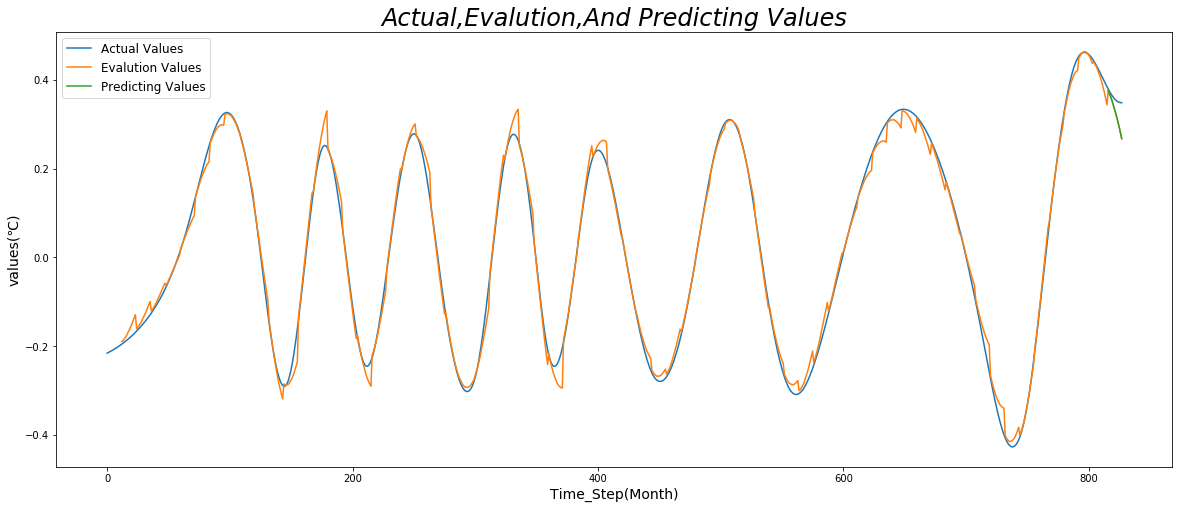

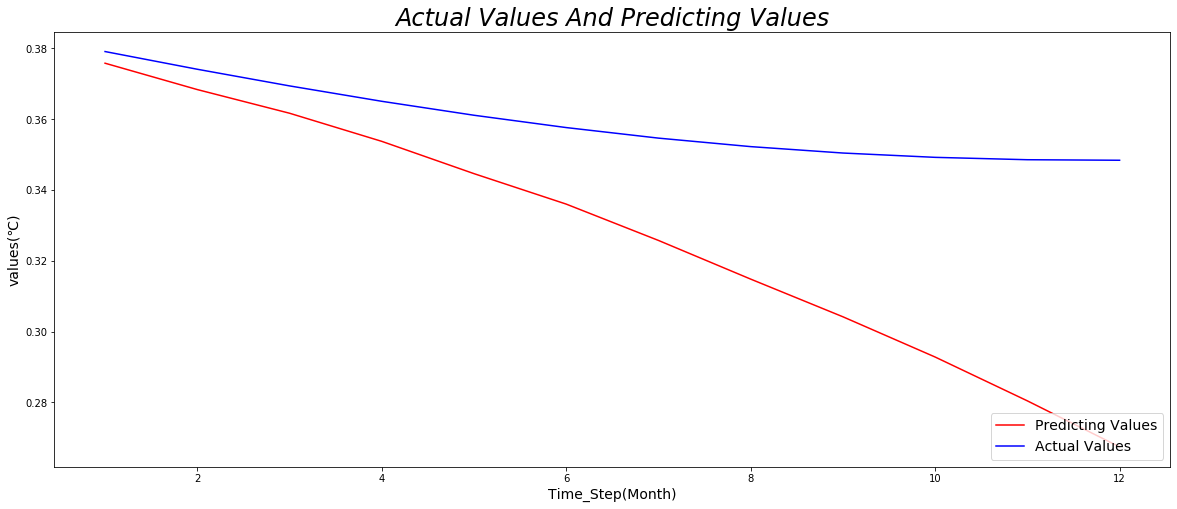

(828,)


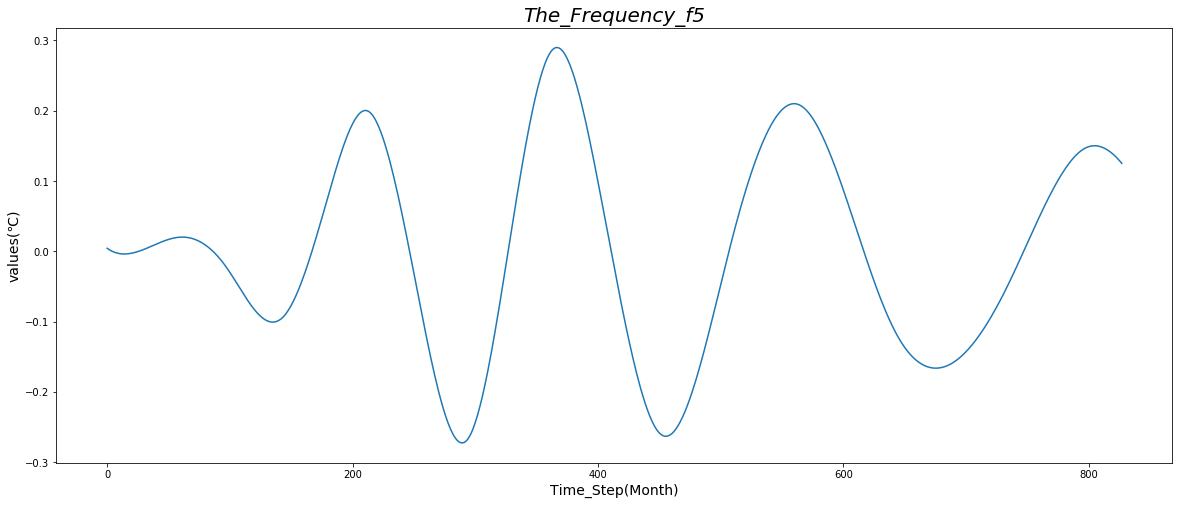

(1, 12, 1)
[0.1436  0.14239 0.14109 0.13969 0.1382  0.13661 0.13494 0.13318 0.13133
 0.1294  0.12738 0.12528]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 4s - loss: 0.0067
Epoch 2/200
 - 1s - loss: 0.0025
Epoch 3/200
 - 1s - loss: 0.0013
Epoch 4/200
 - 1s - loss: 5.0188e-04
Epoch 5/200
 - 1s - loss: 3.5736e-04
Epoch 6/200
 - 1s - loss: 3.3596e-04
Epoch 7/200
 - 1s - loss: 3.9140e-04
Epoch 8/200
 - 1s - loss: 4.3887e-04
Epoch 9/200
 - 1s - loss: 2.8894e-04
Epoch 10/200
 - 1s - loss: 2.6421e-04
Epoch 11/200
 - 1s - loss: 2.2507e-04
Epoch 12/200
 - 1s - loss: 2.5421e-04
Epoch 13/200
 - 1s - loss: 2.9857e-04
Epoch 14/200
 - 1s - loss: 2.1849e-04
Epoch 15/200
 - 1s - loss: 2.6713e-04
Epoch 16/200
 - 2s - loss: 2.3580e-04
Epoch 17/200
 - 1s - loss: 1.9998e-04
Epoch 18/200
 - 1s - loss: 2.1529e-04
Epoch 19/200
 - 1s - loss: 2.3647e-04
Epoch 20/200
 - 1s - loss: 2.3362e-04
Epoch 21/200
 - 1s - loss: 2.7461e-04
Epoch 22/200
 - 1s - loss: 2.3070e-04
Epoch 23/200
 - 1s - loss: 2.1750e-04
Epoch 24/200
 

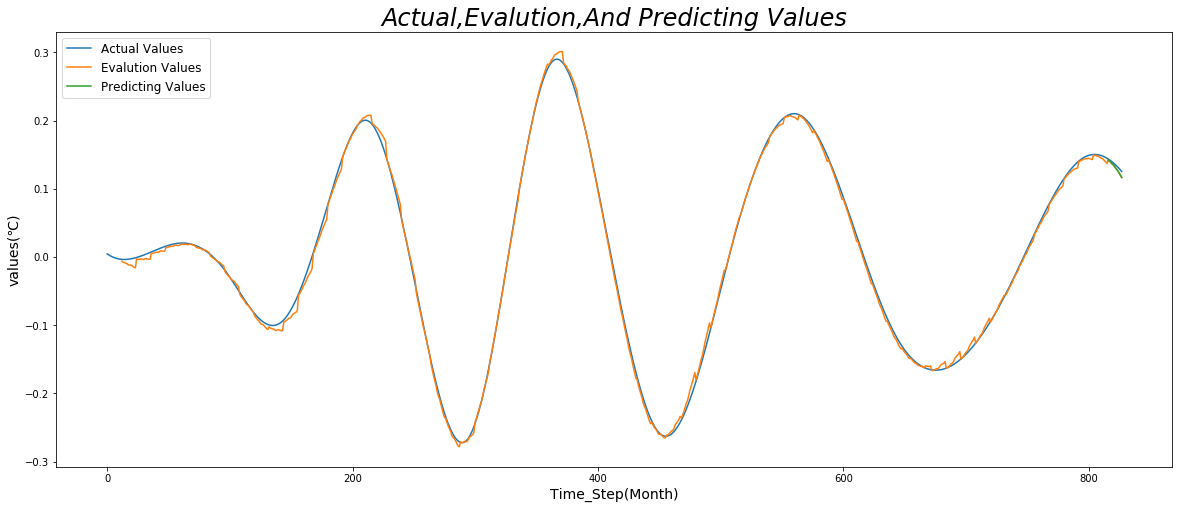

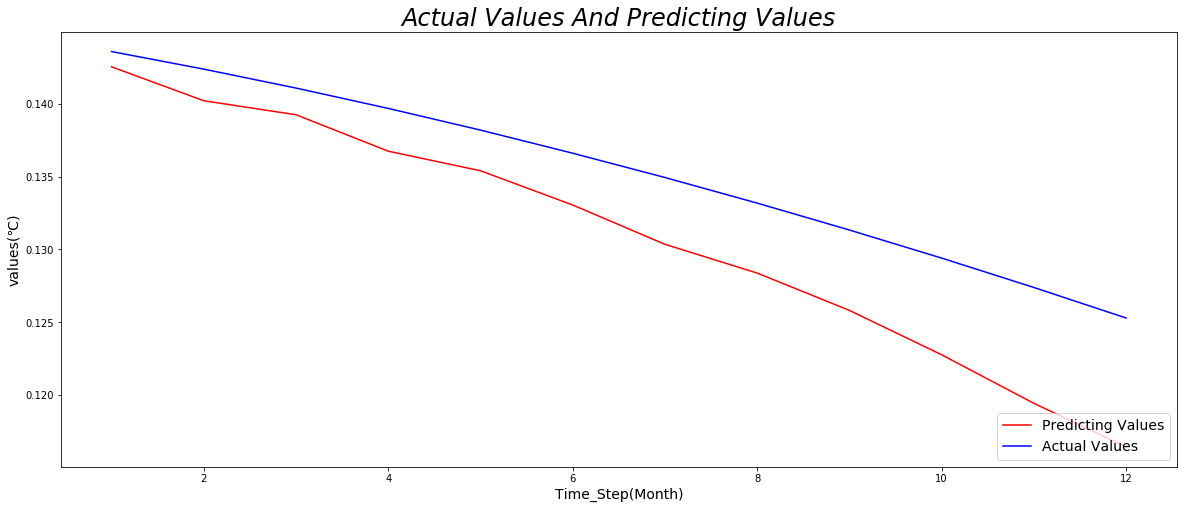

(828,)


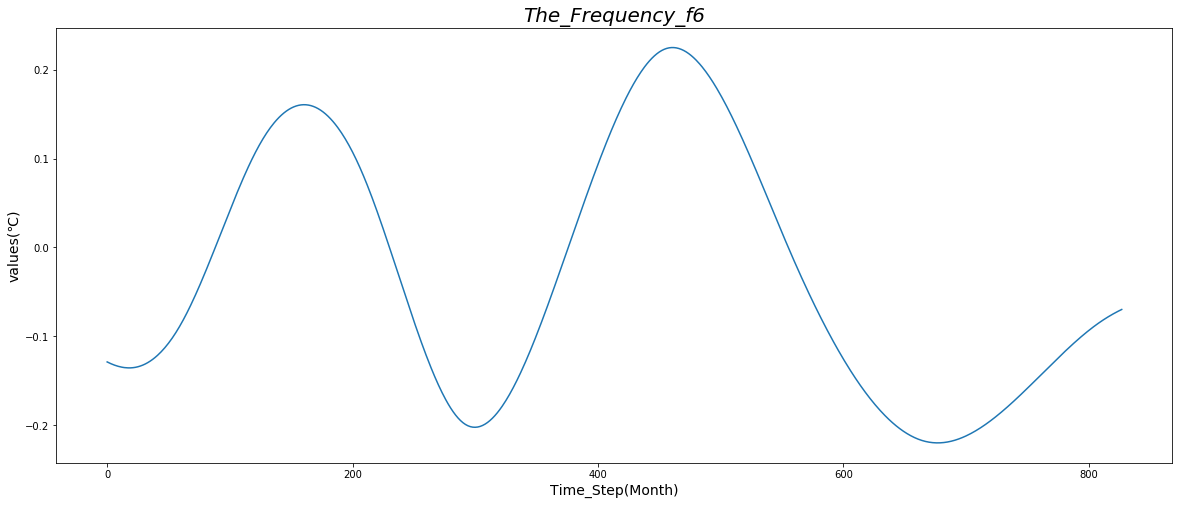

(1, 12, 1)
[-0.078087 -0.077258 -0.076445 -0.075649 -0.074869 -0.074105 -0.073357
 -0.072625 -0.071909 -0.071208 -0.070523 -0.069853]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 4s - loss: 0.0056
Epoch 2/200
 - 1s - loss: 0.0012
Epoch 3/200
 - 1s - loss: 8.5808e-04
Epoch 4/200
 - 1s - loss: 7.3273e-04
Epoch 5/200
 - 1s - loss: 6.5732e-04
Epoch 6/200
 - 1s - loss: 3.9079e-04
Epoch 7/200
 - 1s - loss: 3.1271e-04
Epoch 8/200
 - 1s - loss: 3.0882e-04
Epoch 9/200
 - 1s - loss: 3.1688e-04
Epoch 10/200
 - 1s - loss: 3.0293e-04
Epoch 11/200
 - 1s - loss: 2.1826e-04
Epoch 12/200
 - 1s - loss: 2.2557e-04
Epoch 13/200
 - 1s - loss: 1.7704e-04
Epoch 14/200
 - 1s - loss: 2.2384e-04
Epoch 15/200
 - 1s - loss: 2.3424e-04
Epoch 16/200
 - 1s - loss: 2.3474e-04
Epoch 17/200
 - 1s - loss: 2.5922e-04
Epoch 18/200
 - 1s - loss: 2.2454e-04
Epoch 19/200
 - 1s - loss: 1.9448e-04
Epoch 20/200
 - 1s - loss: 2.0994e-04
Epoch 21/200
 - 1s - loss: 2.0685e-04
Epoch 22/200
 - 1s - loss: 2.1694e-04
Epoch 23/200
 - 1s - los

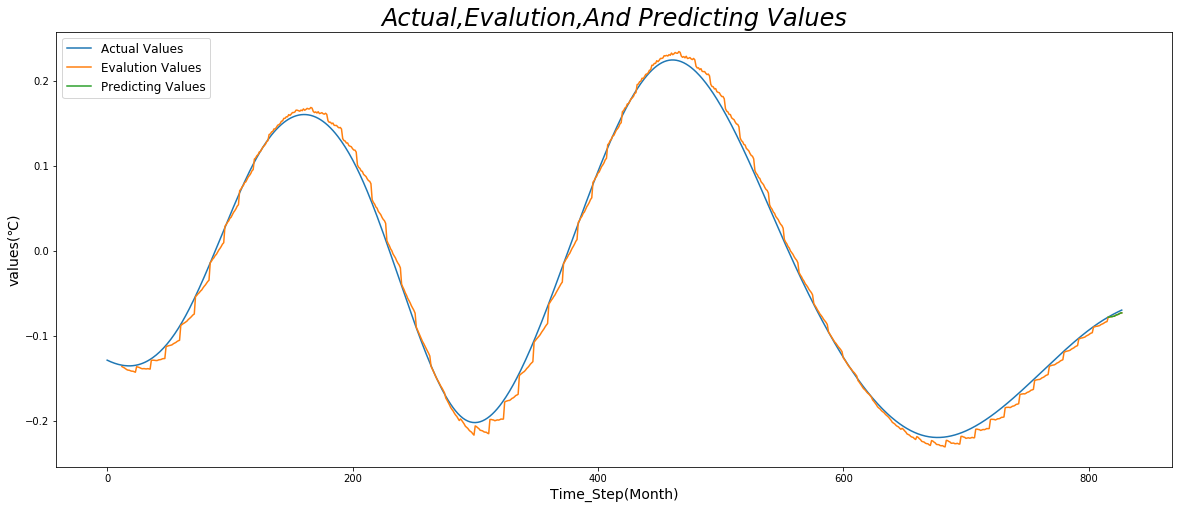

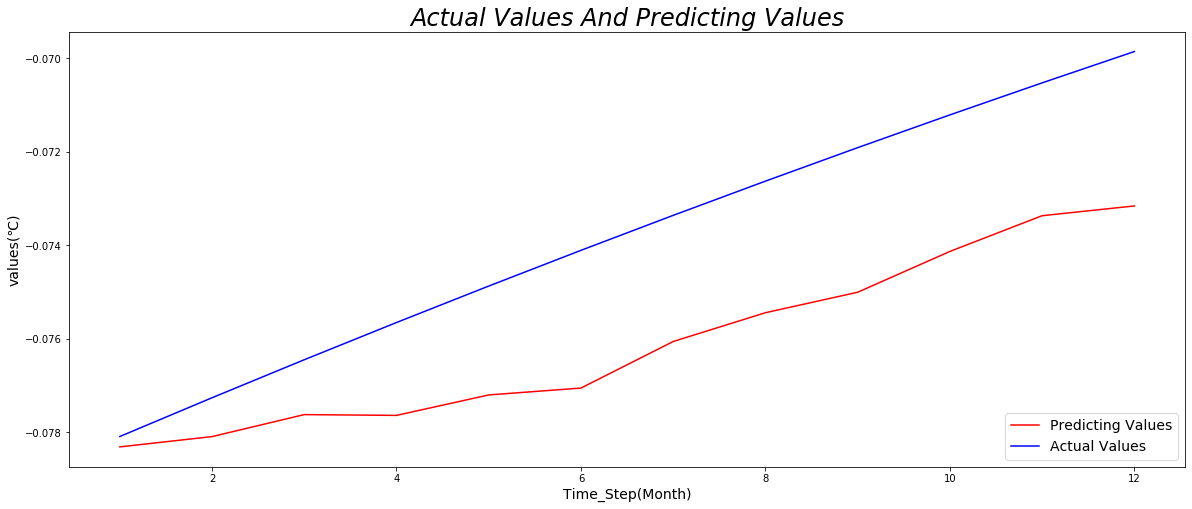

(828,)


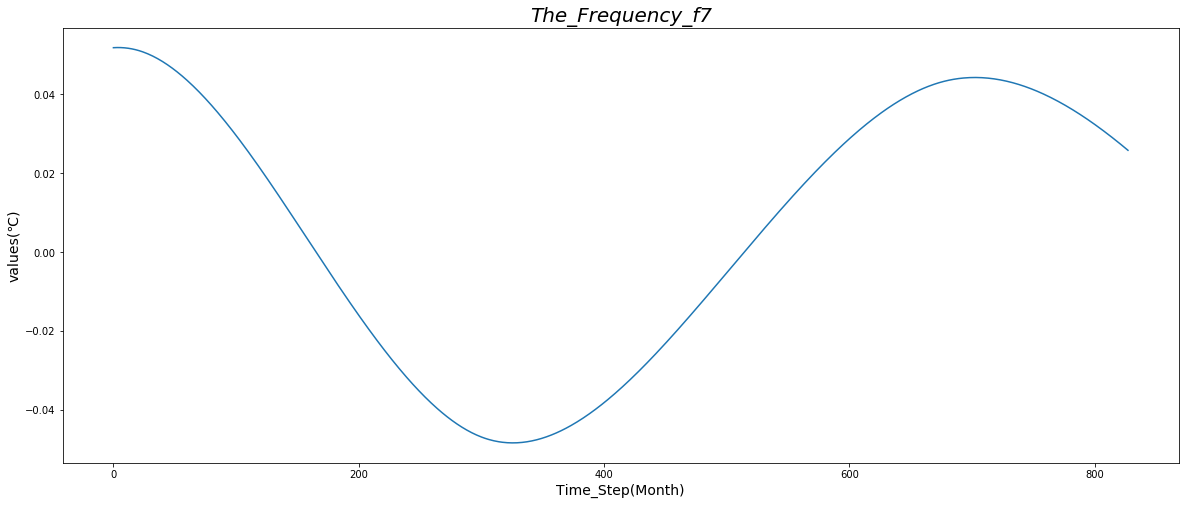

(1, 12, 1)
[0.02861  0.028363 0.028114 0.027865 0.027614 0.027362 0.027108 0.026853
 0.026597 0.026339 0.026081 0.025821]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 4s - loss: 4.7837e-04
Epoch 2/200
 - 1s - loss: 5.5180e-05
Epoch 3/200
 - 1s - loss: 4.2417e-05
Epoch 4/200
 - 1s - loss: 3.4472e-05
Epoch 5/200
 - 1s - loss: 2.6811e-05
Epoch 6/200
 - 1s - loss: 2.7926e-05
Epoch 7/200
 - 1s - loss: 2.4070e-05
Epoch 8/200
 - 1s - loss: 2.2925e-05
Epoch 9/200
 - 1s - loss: 1.9826e-05
Epoch 10/200
 - 1s - loss: 1.9642e-05
Epoch 11/200
 - 1s - loss: 1.9802e-05
Epoch 12/200
 - 1s - loss: 2.1843e-05
Epoch 13/200
 - 1s - loss: 2.3622e-05
Epoch 14/200
 - 1s - loss: 1.8819e-05
Epoch 15/200
 - 1s - loss: 1.9416e-05
Epoch 16/200
 - 1s - loss: 1.6546e-05
Epoch 17/200
 - 1s - loss: 1.7470e-05
Epoch 18/200
 - 1s - loss: 1.7879e-05
Epoch 19/200
 - 1s - loss: 1.3939e-05
Epoch 20/200
 - 1s - loss: 1.8370e-05
Epoch 21/200
 - 1s - loss: 1.7385e-05
Epoch 22/200
 - 1s - loss: 1.7510e-05
Epoch 23/200
 - 1s - loss: 1

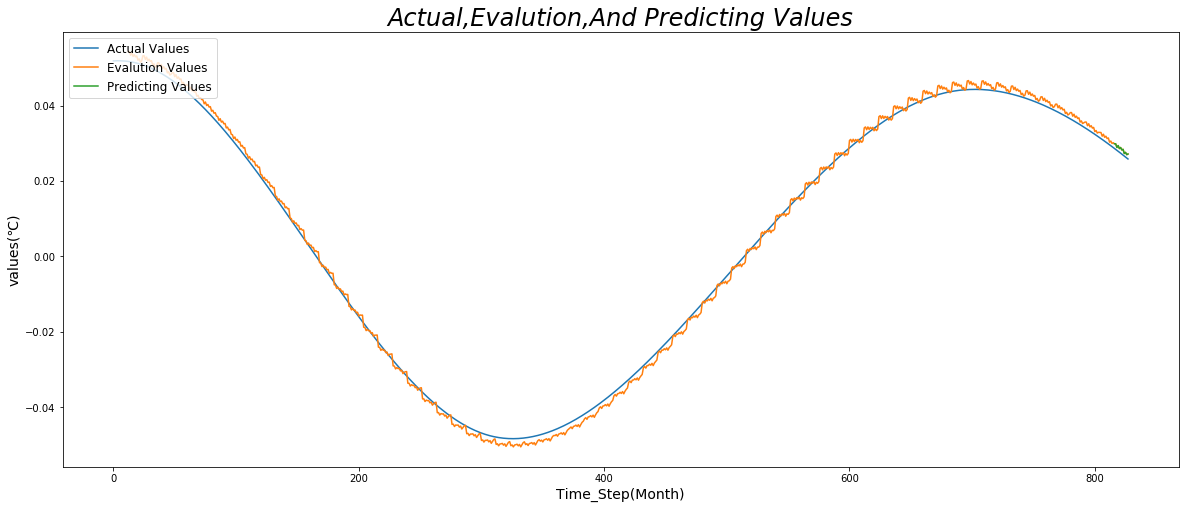

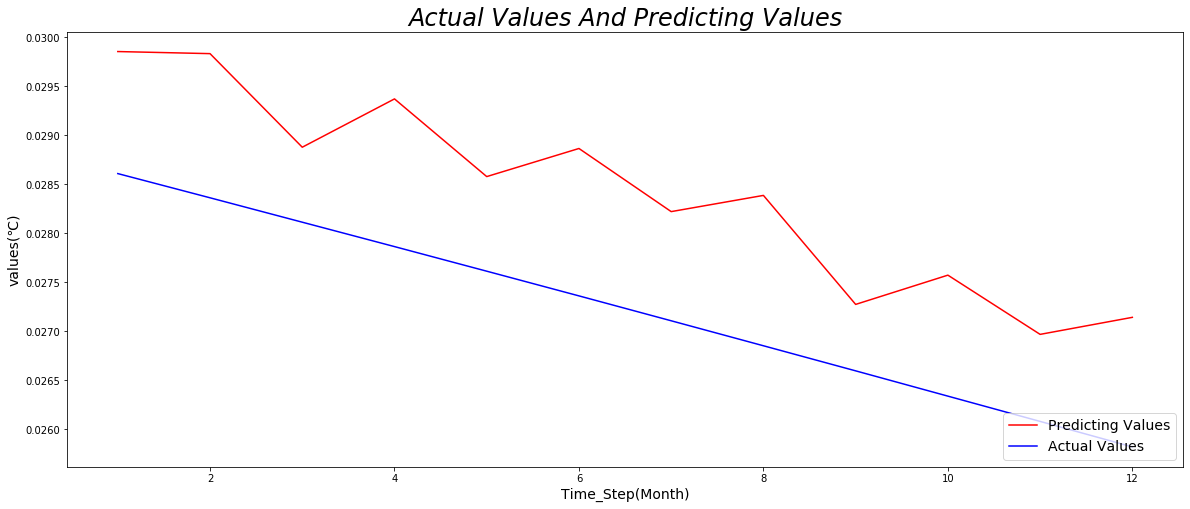

(828,)


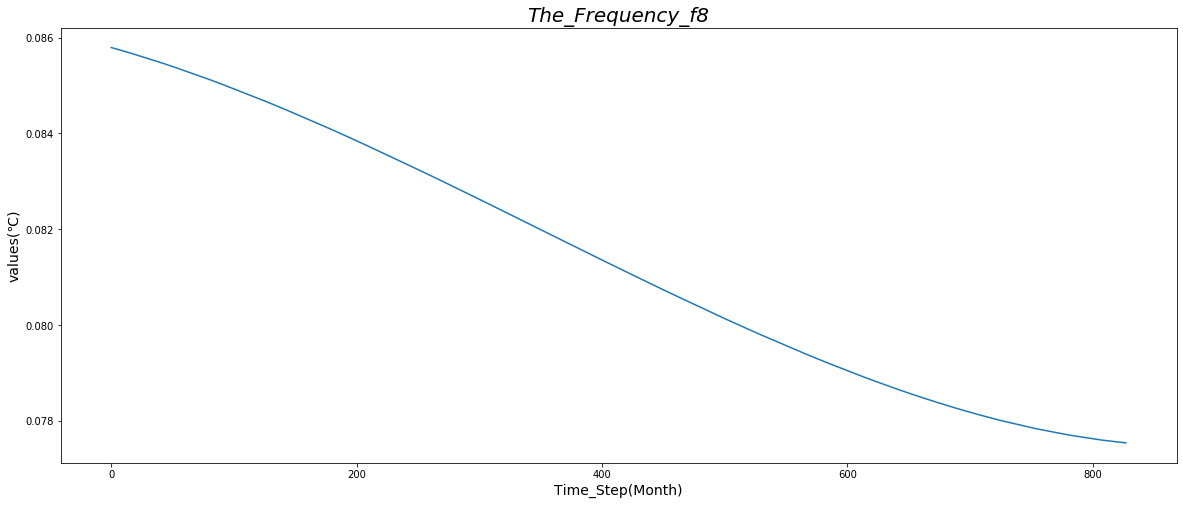

(1, 12, 1)
[0.077574 0.077571 0.077568 0.077565 0.077562 0.077559 0.077556 0.077554
 0.077551 0.077548 0.077546 0.077543]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 4s - loss: 9.7942e-04
Epoch 2/200
 - 1s - loss: 7.1780e-05
Epoch 3/200
 - 1s - loss: 3.5373e-05
Epoch 4/200
 - 1s - loss: 2.3908e-05
Epoch 5/200
 - 1s - loss: 1.8092e-05
Epoch 6/200
 - 1s - loss: 1.4421e-05
Epoch 7/200
 - 1s - loss: 1.1699e-05
Epoch 8/200
 - 1s - loss: 9.6316e-06
Epoch 9/200
 - 1s - loss: 8.0918e-06
Epoch 10/200
 - 1s - loss: 6.7342e-06
Epoch 11/200
 - 1s - loss: 6.2042e-06
Epoch 12/200
 - 1s - loss: 5.0758e-06
Epoch 13/200
 - 1s - loss: 4.7847e-06
Epoch 14/200
 - 1s - loss: 4.4226e-06
Epoch 15/200
 - 1s - loss: 4.0307e-06
Epoch 16/200
 - 1s - loss: 3.7161e-06
Epoch 17/200
 - 1s - loss: 3.2830e-06
Epoch 18/200
 - 1s - loss: 3.0153e-06
Epoch 19/200
 - 1s - loss: 3.0653e-06
Epoch 20/200
 - 1s - loss: 2.9789e-06
Epoch 21/200
 - 1s - loss: 2.5855e-06
Epoch 22/200
 - 1s - loss: 2.1042e-06
Epoch 23/200
 - 1s - loss: 2

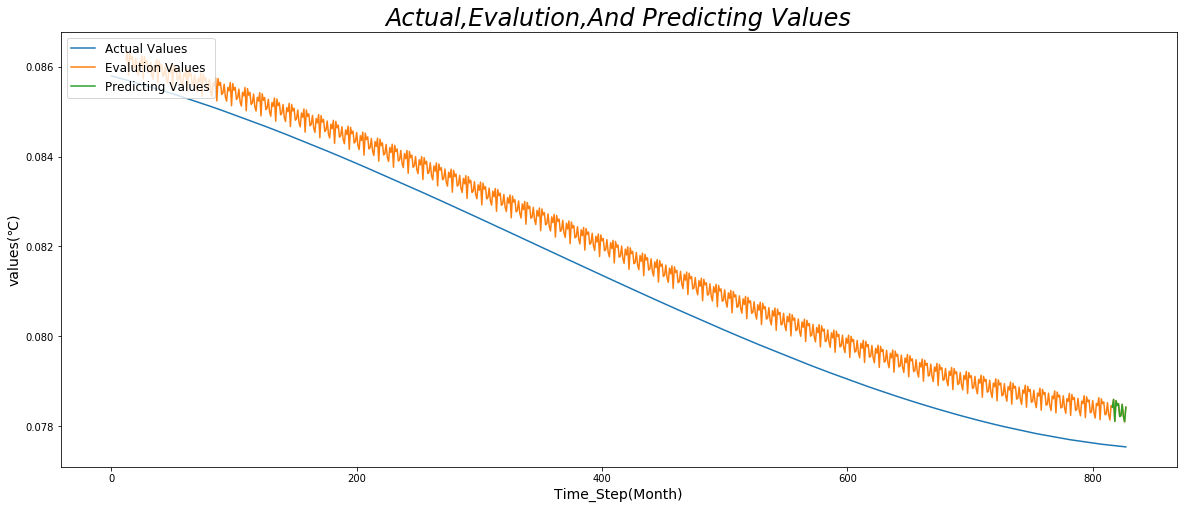

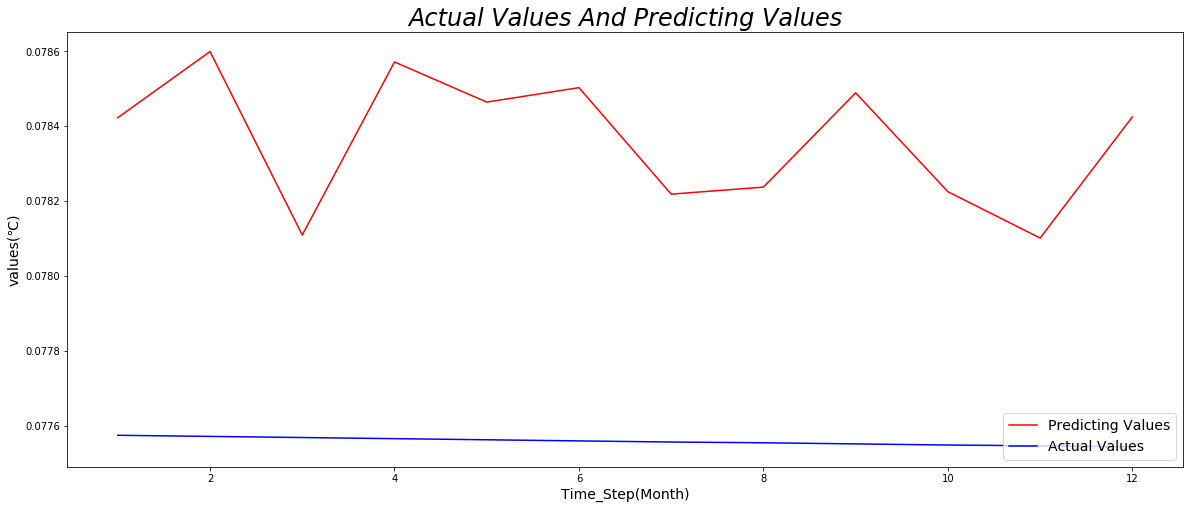

In [5]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]

signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_SoloLstm_EMD_prediction')==False):
    os.makedirs('12_months_SoloLstm_EMD_prediction')
        
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][::]
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_SoloLstm_EMD_prediction/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    print (test.shape)
    print (test[0].reshape(-1))
    
    n_input = 12
    n_out=12
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    print (train_y.shape)
    
    model=build_model(train_x,train_y,n_input,n_out)
    score, scores,predictions = evaluate_model(train, test, n_input)
    trainPredict = model.predict(train)
    print (predictions.reshape(-1))
    
    
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)

# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1)):len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [6]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[0.07842235 0.07859898 0.07810894 0.07857117 0.0784639  0.07850251
 0.07821809 0.07823686 0.07848877 0.0782246  0.07810088 0.07842439]
[array([-0.28373  , -0.20753  , -0.069358 ,  0.029479 ,  0.18765  ,
        0.20383  , -0.017003 , -0.14515  , -0.14641  ,  0.0092768,
        0.1346   ,  0.035037 ]), array([-0.29143 , -0.354   , -0.38141 , -0.36968 , -0.31534 , -0.21508 ,
       -0.071875,  0.086582,  0.22809 ,  0.32458 ,  0.36537 ,  0.34646 ]), array([0.0056482, 0.12307  , 0.23839  , 0.34909  , 0.45314  , 0.54868  ,
       0.63381  , 0.70665  , 0.76531  , 0.80793  , 0.83261  , 0.83806  ]), array([-0.88131, -0.90671, -0.92735, -0.94342, -0.95507, -0.96249,
       -0.96584, -0.96529, -0.96101, -0.95309, -0.94162, -0.92675]), array([0.37911, 0.37411, 0.36941, 0.36506, 0.36112, 0.35764, 0.35466,
       0.35226, 0.35045, 0.34923, 0.34856, 0.34841]), array([0.1436 , 0.14239, 0.14109, 0.13969, 0.1382 , 0.13661, 0.13494,
       0.13318, 0.13133, 0.1294 , 0.12738, 0.12528]), array([-0.078087,

In [7]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
[[-0.28373  ]
 [-0.20753  ]
 [-0.069358 ]
 [ 0.029479 ]
 [ 0.18765  ]
 [ 0.20383  ]
 [-0.017003 ]
 [-0.14515  ]
 [-0.14641  ]
 [ 0.0092768]
 [ 0.1346   ]
 [ 0.035037 ]]
[[-0.28]
 [-0.21]
 [-0.07]
 [ 0.03]
 [ 0.19]
 [ 0.2 ]
 [-0.02]
 [-0.15]
 [-0.15]
 [ 0.01]
 [ 0.13]
 [ 0.04]]
-----------------------------------
observe value:[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
[[-0.57516  ]
 [-0.56153  ]
 [-0.450768 ]
 [-0.340201 ]
 [-0.12769  ]
 [-0.01125  ]
 [-0.088878 ]
 [-0.058568 ]
 [ 0.08168  ]
 [ 0.3338568]
 [ 0.49997  ]
 [ 0.381497 ]]
[[-0.58]
 [-0.56]
 [-0.45]
 [-0.34]
 [-0.13]
 [-0.01]
 [-0.09]
 [-0.06]
 [ 0.08]
 [ 0.33]
 [ 0.5 ]
 [ 0.38]]
-----------------------------------
observe value:[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70

In [8]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i]))
    predicted_values = np.add(predicted_values, prediction_in_one[i])
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.4909233  -0.535619   -0.5697219  -0.5096948  -0.43255585 -0.27633804
 -0.08101215  0.18896504  0.35956493  0.51588786  0.5096617   0.41520754]
[-0.49092329 -0.53561902 -0.56972188 -0.50969481 -0.43255585 -0.27633804
 -0.08101215  0.18896504  0.35956493  0.51588786  0.50966167  0.41520754]
the 1 frequence:
predicted_value:[-0.27654877 -0.32380706 -0.33108166 -0.30785635 -0.2536384  -0.18306053
 -0.09588337 -0.00452963  0.08230295  0.16250116  0.21793847  0.24353066]
[-0.76747206 -0.85942608 -0.90080354 -0.81755117 -0.68619424 -0.45939857
 -0.17689552  0.18443541  0.44186788  0.67838901  0.72760014  0.6587382 ]
the 2 frequence:
predicted_value:[0.00437482 0.10841599 0.21011096 0.3038669  0.3873656  0.45852914
 0.5143426  0.5527405  0.57821894 0.5883438  0.58543956 0.56629527]
[-7.63097238e-01 -7.51010090e-01 -6.90692574e-01 -5.13684273e-01
 -2.98828632e-01 -8.69423151e-04  3.37447084e-01  7.37175921e-01
  1.020086

[[-0.9]
 [-0.8]
 [-0.6]
 [-0.4]
 [-0.1]
 [ 0.1]
 [ 0.1]
 [ 0.2]
 [ 0.4]
 [ 0.7]
 [ 0.9]
 [ 0.8]]
[-1.02414218 -1.03851225 -0.98843682 -0.81726721 -0.59732366 -0.28268347
  0.08707089  0.52677304  0.86168703  1.16921931  1.28338614  1.26744952]


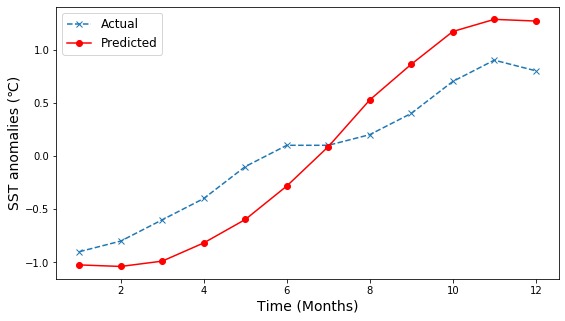

In [10]:
print (round_true_values)
print (predicted_values)

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_the_final_predict_real_result.png')
plt.show() 
 